<a href="https://colab.research.google.com/github/winteryao7/DeepLearningTutorial/blob/main/Mousavi_et_al_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load and explore Meier dataset
Hosted at https://scedc.caltech.edu/data/deeplearning.html.  Download onsetWforms_meier19jgr_pub1_0_woJP.h5 at the bottom.

In [ ]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle

In [ ]:
meier_h5 = h5py.File('/content/drive/Shared drives/Capstone/Meier Dataset/onsetWforms_meier19jgr_pub1_0_woJP.h5', 'r')

list(meier_h5.keys())

['noise', 'quake', 'tele']

In [ ]:
meier_quake = meier_h5['quake']['wforms']
meier_quake.shape

(3, 107318, 601)

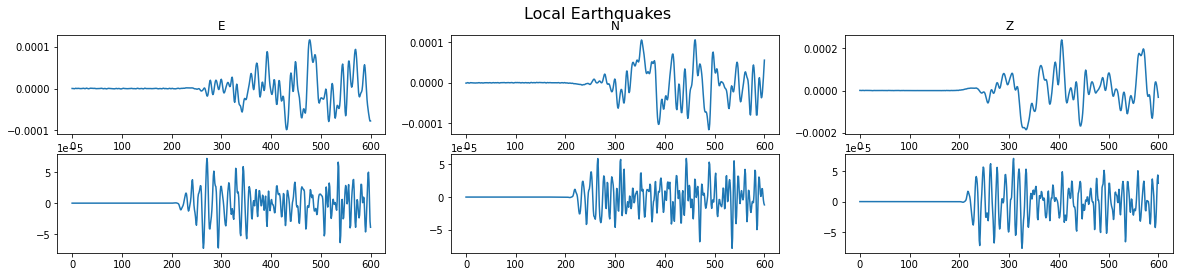

In [ ]:
quake_500 = meier_quake[:,500,:]
quake_10000 = meier_quake[:,10000,:]

fig, axs = plt.subplots(2,3,figsize=(20,4))

fig.suptitle('Local Earthquakes', fontsize=16)

axs[0,0].set_title('E')
axs[0,0].plot(quake_500[0,:])
axs[0,1].set_title('N')
axs[0,1].plot(quake_500[1,:])
axs[0,2].set_title('Z')
axs[0,2].plot(quake_500[2,:])

axs[1,0].plot(quake_10000[0,:])
axs[1,1].plot(quake_10000[1,:])
axs[1,2].plot(quake_10000[2,:]);

In [ ]:
meier_tele = meier_h5['tele']['wforms']
meier_tele.shape

(3, 7544, 601)

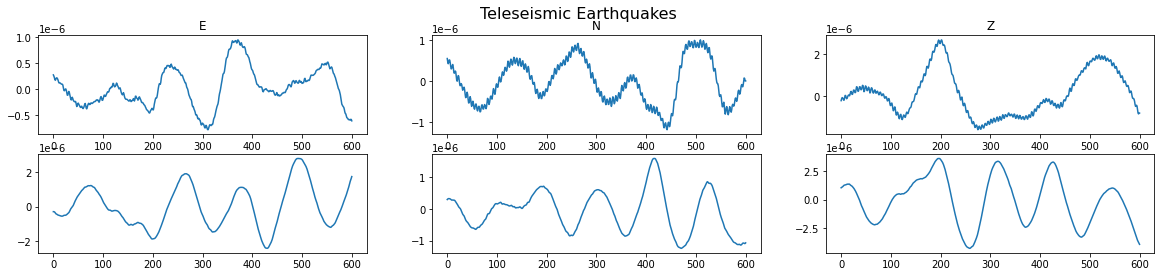

In [ ]:
tele_500 = meier_tele[:,500,:]
tele_10000 = meier_tele[:,6000,:]

fig, axs = plt.subplots(2,3,figsize=(20,4))

fig.suptitle('Teleseismic Earthquakes', fontsize=16)

axs[0,0].set_title('E')
axs[0,0].plot(tele_500[0,:])
axs[0,1].set_title('N')
axs[0,1].plot(tele_500[1,:])
axs[0,2].set_title('Z')
axs[0,2].plot(tele_500[2,:])

axs[1,0].plot(tele_10000[0,:])
axs[1,1].plot(tele_10000[1,:])
axs[1,2].plot(tele_10000[2,:]);

Mousavi used 9,200 vertical component waveforms, roughly evenly split between local and teleseismic events.  He included some Japanese waveforms in his data which aren't available now, so I'll just use 10,000 from California instead.  Should be close enough to reproduce his results.

In [ ]:
RANDOM_SEED = 42
p = np.sort(np.random.permutation(len(meier_tele[2]))[:5000])
meier_quake_sample = meier_quake[2,p,:]
meier_tele_sample = meier_tele[2,p,:]

meier_quake_sample.shape

(5000, 601)

# Compute spectrograms according to Mousavi's specifications
I wasn't able to figure out the Butterworth filter.  Need to revisit this to completely reproduce Mousavi's pipeline.

In [ ]:
from scipy.signal import butter
from scipy import signal

In [ ]:
# Params for bandpass filtering
lowcut = 1
highcut = 20
order = 4
Fs = 100 # frequency

spectrograms = []
max_val = 0.0

for quake_wform in meier_quake_sample:
  # ToDo: implement the Butterworth filter
  #bpf = butter(quake_wform, lowcut, highcut, Fs, order=order)
  bpf = quake_wform
  bpf = bpf/np.max(bpf)

  f, t, Pxx = signal.stft(bpf, fs = 100, nfft=30, nperseg=15, noverlap=2)
  Pxx = np.abs(Pxx)

  spec_max = np.amax(Pxx)
  if spec_max > max_val:
    max_val = spec_max

  spectrograms.append(Pxx)

for tele_wform in meier_tele_sample:
  # ToDo: implement the Butterworth filter
  #bpf = butter(tele_wform, lowcut, highcut, Fs, order=order)
  bpf = tele_wform
  bpf = bpf/np.max(bpf)

  f, t, Pxx = signal.stft(bpf, fs = 100, nfft=30, nperseg=15, noverlap=2)
  Pxx = np.abs(Pxx)

  spec_max = np.amax(Pxx)
  if spec_max > max_val:
    max_val = spec_max

  spectrograms.append(Pxx)

spectrograms_arr = np.asarray(spectrograms)
spectrograms_arr/max_val

spectrograms_arr.shape

(10000, 16, 48)

In [ ]:
X = spectrograms_arr
y = np.asarray([0]*5000 + [1]*5000)

X, y = shuffle(X, y, random_state=RANDOM_SEED)

#Deep Embedded Clustering

In [ ]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Dropout, Reshape 
from keras.layers import Bidirectional, BatchNormalization, ZeroPadding1D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
from keras import regularizers
from tensorflow.keras.layers import Layer, InputSpec
from scipy.optimize import linear_sum_assignment as linear_assignment
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
from datetime import datetime
from sklearn.manifold import TSNE

In [ ]:
N_CLUSTERS = 2 # local and teleseismic

In [ ]:
def get_color(label):
  colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
  return colors[label]

def get_colors(labels):
  colors = []
  for label in labels:
    colors.append(get_color(label))
  return colors

def acc(y_true, y_pred):
  """
  Calculate clustering accuracy. Require scikit-learn installed

  # Arguments
      y: true labels, numpy.array with shape `(n_samples,)`
      y_pred: predicted labels, numpy.array with shape `(n_samples,)`

  # Return
      accuracy, in [0,1]
  """
  y_true = y_true.astype(np.int64)
  assert y_pred.size == y_true.size
  D = max(y_pred.max(), y_true.max()) + 1
  w = np.zeros((D, D), dtype=np.int64)
  for i in range(y_pred.size):
      w[y_pred[i], y_true[i]] += 1
  from scipy.optimize import linear_sum_assignment as linear_assignment
  ind = linear_assignment(w.max() - w)
  return w[ind[0], ind[1]].sum() * 1.0 / y_pred.size

In [ ]:
inp = Input(shape=(16, 48, 1))  
e = Conv2D(4, (3, 3), activation='tanh', padding='same')(inp)
e = MaxPooling2D((2, 2), padding='same')(e)
e = Conv2D(2, (3, 3), activation='tanh', padding='same')(e)
e = MaxPooling2D((2, 2), padding='same')(e)
e = Conv2D(1, (3, 3), activation='tanh', padding='same')(e)
e = MaxPooling2D((2, 2), padding='same')(e)

shape_before_flattening = K.int_shape(e)
encoded = Flatten()(e)
d = Reshape(shape_before_flattening[1:])(encoded)

d = Conv2D(1, (3, 3), activation='tanh', padding='same')(d)
d = UpSampling2D((2, 2))(d)
d = Conv2D(2, (3, 3), activation='tanh', padding='same')(d)
d = UpSampling2D((2, 2))(d)
d = Conv2D(4, (3, 3), activation='tanh', padding='same')(d)
d = UpSampling2D((2, 2))(d)
decoded = Conv2D(1, (3, 3), padding='same')(d)

autoencoder = Model(inputs=inp, outputs=decoded, name='autoencoder')
encoder = Model(inputs=inp, outputs=encoded, name='encoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 48, 4)         40        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 24, 4)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 24, 2)          74        
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 12, 2)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 12, 1)          

In [ ]:
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X, X, batch_size=128, epochs=50)

Epoch 1/50
79/79 [==============================] - 5s 11ms/step - loss: 0.0127
Epoch 2/50
79/79 [==============================] - 1s 8ms/step - loss: 0.0097
Epoch 3/50
79/79 [==============================] - 1s 8ms/step - loss: 0.0088
Epoch 4/50
79/79 [==============================] - 1s 8ms/step - loss: 0.0063
Epoch 5/50
79/79 [==============================] - 1s 8ms/step - loss: 0.0055
Epoch 6/50
79/79 [==============================] - 1s 8ms/step - loss: 0.0053
Epoch 7/50
79/79 [==============================] - 1s 8ms/step - loss: 0.0051
Epoch 8/50
79/79 [==============================] - 1s 8ms/step - loss: 0.0049
Epoch 9/50
79/79 [==============================] - 1s 8ms/step - loss: 0.0048
Epoch 10/50
79/79 [==============================] - 1s 8ms/step - loss: 0.0047
Epoch 11/50
79/79 [==============================] - 1s 8ms/step - loss: 0.0047
Epoch 12/50
79/79 [==============================] - 1s 9ms/step - loss: 0.0046
Epoch 13/50
79/79 [=============================

In [ ]:
#### clustering layers
class ClusteringLayer(Layer):
    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) 
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
print('...Finetuning...')   
clustering_layer = ClusteringLayer(N_CLUSTERS, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=[clustering_layer, autoencoder.output])
model.compile(loss=['kld', 'mse'], loss_weights=[0.1, 0.9], optimizer='adam') # ToDo: Verify that changing 1.0 to 0.9 is ok to do.

...Finetuning...


In [ ]:
### initializing the weights using Kmean and assigning them to the model
kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=20, random_state=RANDOM_SEED)
y_pred = kmeans.fit_predict(encoder.predict(X))
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

print(f'Pre-train accuracy: {np.round(acc(y, y_pred), 5)}')

y_pred_pre = y_pred

Pre-train accuracy: 0.7414


In [ ]:
enc = encoder.predict(X)
tsne_pre = TSNE(random_state=RANDOM_SEED).fit_transform(enc)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


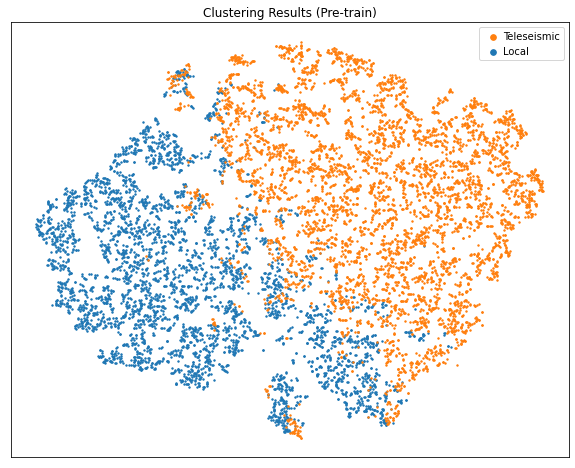

In [ ]:
fig = plt.figure(figsize=(10,8))

ax1 = plt.gca()
ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)
plt.title(f'Clustering Results (Pre-train)')

#blue, orange
labels = ['Local', 'Teleseismic']

for i in range(len(labels)):
  idxs = np.argwhere(y_pred_pre==i)
  plt.scatter(tsne_pre[idxs,0], tsne_pre[idxs,1], s=2, c=get_color(i), label=labels[i])
  
plt.legend()
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
lgnd = plt.legend(handles[::-1], labels[::-1], markerscale=4, handletextpad=0)

In [ ]:
## parameters for the finetuning
batch_size=256
tol = 0.001 # tolerance threshold to stop training
loss = 0
index = 0
maxiter = 5000
update_interval = 150
index_array = np.arange(X.shape[0])

###############################################################################
### simultaneous optimization and clustering
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q, _  = model.predict(X, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p       
        y_pred = q.argmax(1) # evaluate the clustering performance

        if y is not None:
            ac = np.round(acc(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f' % (ite, ac), ' ; loss=', loss)
        else:
          print(f'Iter: {ite}')

        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)

        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            break    
    
    idx = index_array[index * batch_size: min((index+1) * batch_size, X.shape[0])]
    loss = model.train_on_batch(x=X[idx], y=[p[idx], X[idx]])
    index = index + 1 if (index + 1) * batch_size <= X.shape[0] else 0

y_pred_tuned = y_pred

Iter 0: acc = 0.74140  ; loss= 0
Iter 150: acc = 0.74100  ; loss= [0.00387 0.      0.0043 ]
Iter 300: acc = 0.74170  ; loss= [0.00382 0.      0.00424]
Iter 450: acc = 0.74560  ; loss= [3.63e-03 2.00e-05 4.04e-03]
Iter 600: acc = 0.74610  ; loss= [0.00367 0.00014 0.00406]
Iter 750: acc = 0.74890  ; loss= [0.004   0.00063 0.00437]
Iter 900: acc = 0.76700  ; loss= [0.00442 0.00392 0.00448]
Iter 1050: acc = 0.77870  ; loss= [0.00607 0.01967 0.00456]
Iter 1200: acc = 0.78340  ; loss= [0.00885 0.04482 0.00485]
Iter 1350: acc = 0.78840  ; loss= [0.00956 0.05046 0.00502]
Iter 1500: acc = 0.79470  ; loss= [0.00954 0.05005 0.00504]
Iter 1650: acc = 0.79810  ; loss= [0.00954 0.05156 0.00487]
Iter 1800: acc = 0.80440  ; loss= [0.01125 0.06633 0.00513]
Iter 1950: acc = 0.81260  ; loss= [0.01044 0.0575  0.00522]
Iter 2100: acc = 0.82130  ; loss= [0.01026 0.05585 0.0052 ]
Iter 2250: acc = 0.82960  ; loss= [0.01012 0.05649 0.00496]
Iter 2400: acc = 0.83600  ; loss= [0.01134 0.0665  0.00521]
Iter 2550:

In [ ]:
enc = encoder.predict(X)
tsne_tuned = TSNE(random_state=RANDOM_SEED).fit_transform(enc)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [ ]:
fig = plt.figure(figsize=(10,8))

ax1 = plt.gca()
ax1.axes.xaxis.set_visible(False)
ax1.axes.yaxis.set_visible(False)
plt.title(f'Clustering Results (Tuned)')

#blue, orange
labels = ['Local', 'Teleseismic']

for i in range(len(labels)):
  idxs = np.argwhere(y_pred_pre==i)
  plt.scatter(tsne_tuned[idxs,0], tsne_tuned[idxs,1], s=2, c=get_color(i), label=labels[i])
  
plt.legend()
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
lgnd = plt.legend(handles[::-1], labels[::-1], markerscale=4, handletextpad=0)